In [1]:
import os
os.chdir("..")

In [2]:
import json
import math
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score

In [3]:
tqdm.pandas()

# Experiments from paper

## Helper functions

In [4]:
def get_median(distr, start, end, step):
    x = np.arange(start, end, step)
    exp_f = np.exp(distr)
    alpha = exp_f.sum() * 0.5
    try:
        median_low = x[exp_f.cumsum() <= alpha][-1]
    except IndexError:
        median_low = start
    try:
        median_high = x[::-1][exp_f[::-1].cumsum() < alpha][-1]
    except IndexError:
        median_high = end
    median_avg = (median_low + median_high) / 2
    return median_avg

def get_thresholds_from_record(record, start=0, end=1, step=0.01):
    thresholds = dict()
    for claim in record:
        thresholds[claim] = {'threshold': get_median(record[claim]['distributions'][-1], start, end, step)}
    return thresholds

def keep_only_top_claim(scores_dict):
    new_dict = dict()
    
    for cl in CLASSES:
        rel_claims = [t for t in claims if t[:3] == cl]
        cl_dict = {t: scores_dict[t] for t in rel_claims}
        highest_t = max(cl_dict, key = cl_dict.get)
        for t in rel_claims:
            if t == highest_t:
                new_dict[t] = scores_dict[t]
            else:
                new_dict[t] = 0
    return new_dict

def get_multi_pred(row, column, claims_dict, thresholds=None, black_list=None, min_length=1):
    if thresholds is None:
        thresholds = {t: {'threshold': 0.0} for t in claims_dict}
    if black_list is None:
        black_list = []
    result = list()
    if isinstance(row[column], list):
        zsl_scores = {k:row[column][0][claims_dict[k]] for k in claims_dict}
    else:
        zsl_scores = {k:row[column][claims_dict[k]] for k in claims_dict}
    for c in CLASSES:
        sub_pred = {k: zsl_scores[k] for k in zsl_scores if k[:3] == c and not k in black_list}
        if len([k for k in sub_pred if sub_pred[k] > thresholds[k]['threshold']]) >= min_length:
            result.append(1)
        else:
            result.append(0)
    return result


def get_binary_pred(row, claim_class, column, claims_dict, thresholds=None, black_list=None, min_length=1):
    if thresholds is None:
        thresholds = {t: {'threshold': 0.0} for t in claims_dict}
    if black_list is None:
        black_list = []
    result = list()
    if isinstance(row[column], list):
        zsl_scores = {k:row[column][0][claims_dict[k]] for k in claims_dict}
    else:
        zsl_scores = {k:row[column][claims_dict[k]] for k in claims_dict}

    sub_pred = {k: zsl_scores[k] for k in zsl_scores if k[:3] == claim_class and not k in black_list}
    if len([k for k in sub_pred if sub_pred[k] > thresholds[k]['threshold']]) >= min_length:
        return 1
    else:
        return 0

## 1: Evaluation against baselines

### Climate Change Contrarianism detection

In [34]:
test_df = pd.read_pickle('./data/climate_change/testing.pkl')

In [35]:
CLASSES = ['1_1', '1_2', '1_3', '1_4', '1_6', '1_7']

In [36]:
with open("./data/climate_change/claims.json") as file:
    claims = json.load(file)

claims_descr = claims["class_descr"]
del claims["class_descr"]

In [37]:
inverse_claims = {claims[k]: k for k in claims}

#### Baseline 1: Fine-tuned BERT

In [106]:
print(classification_report(test_df['multi_annot'].to_list(), test_df['BERT'].to_list(), target_names=CLASSES))

              precision    recall  f1-score   support

         1_1       0.67      0.86      0.76        36
         1_2       0.56      0.42      0.48        12
         1_3       0.63      0.35      0.45        48
         1_4       0.54      0.89      0.67        70
         1_6       0.69      0.92      0.79        24
         1_7       0.40      0.47      0.43        34

   micro avg       0.57      0.68      0.62       224
   macro avg       0.58      0.65      0.60       224
weighted avg       0.58      0.68      0.60       224
 samples avg       0.06      0.06      0.06       224



/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Baseline 2: SBERT cosine similarity with threshold-tuning

In [11]:
with open('./data/bisection_records/CCC_SBERT.json') as file:
    sbert_record = json.load(file)

In [12]:
sbert_thresholds = get_thresholds_from_record(sbert_record, start=-1, end=1)

In [13]:
test_df['pred_multi'] = test_df.apply(lambda x: get_multi_pred(x, 'sbert_cosine', claims, thresholds=sbert_thresholds), axis=1)

In [14]:
print(classification_report(test_df['multi_annot'].to_list(), test_df['pred_multi'].to_list(), target_names=CLASSES))

              precision    recall  f1-score   support

         1_1       0.43      0.89      0.58        36
         1_2       0.20      0.08      0.12        12
         1_3       0.64      0.15      0.24        48
         1_4       0.40      0.44      0.42        70
         1_6       0.52      0.96      0.68        24
         1_7       0.50      0.50      0.50        34

   micro avg       0.45      0.50      0.47       224
   macro avg       0.45      0.50      0.42       224
weighted avg       0.47      0.50      0.43       224
 samples avg       0.04      0.04      0.04       224



/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
datapoints = list()
for k in sbert_record:
    datapoints += sbert_record[k]['texts']
len(set(datapoints))

680

#### Baseline 3: BART MNLI model with unique threshold (Zero-Shot approach)

In [16]:
artificial_thresholds = {k: {'threshold': 0.5} for k in claims}

In [17]:
test_df['pred_multi'] = test_df.apply(lambda x: get_multi_pred(x, 'FSL_BART', claims, thresholds=artificial_thresholds), axis=1)

In [18]:
print(classification_report(test_df['multi_annot'].to_list(), test_df['pred_multi'].to_list(), target_names=CLASSES))

              precision    recall  f1-score   support

         1_1       0.22      0.69      0.34        36
         1_2       0.06      1.00      0.11        12
         1_3       0.03      0.98      0.06        48
         1_4       0.47      0.80      0.59        70
         1_6       0.29      0.96      0.45        24
         1_7       0.01      0.97      0.03        34

   micro avg       0.05      0.88      0.09       224
   macro avg       0.18      0.90      0.26       224
weighted avg       0.23      0.88      0.31       224
 samples avg       0.03      0.07      0.04       224



/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Baseline 4: BART MNLI model with Temperature Scaling

In [11]:
sample_sizes = [5, 10, 20, 40, 80, 160]

In [12]:
artificial_thresholds = {k: {'threshold': 0.5} for k in claims}

In [15]:
for samp_size in sample_sizes:
    test_df['pred_multi'] = test_df.apply(lambda x: get_multi_pred(x, 'Temp_Scaling_BART_' + str(samp_size), claims, thresholds=artificial_thresholds), axis=1)
    print(samp_size, ': %.3f' % f1_score(test_df['multi_annot'].to_list(), test_df['pred_multi'].to_list(), average="micro"))

5 : 0.161
10 : 0.220
20 : 0.205
40 : 0.154
80 : 0.193
160 : 0.188


#### Ours 1: Few-shots NLI approach using BART MNLI

In [9]:
with open('./data/bisection_records/CCC_BART.json') as file:
    bart_record = json.load(file)

In [10]:
bart_thresholds = get_thresholds_from_record(bart_record, start=0, end=1)

In [70]:
test_df['pred_multi'] = test_df.apply(lambda x: get_multi_pred(x, 'FSL_BART', claims, thresholds=bart_thresholds), axis=1)

In [83]:
print(classification_report(test_df['multi_annot'].to_list(), test_df['pred_multi'].to_list(), target_names=CLASSES))

              precision    recall  f1-score   support

         0_0       0.97      0.97      0.97      2405
         1_1       0.69      0.54      0.61        37
         1_2       0.30      0.19      0.23        16
         1_3       0.39      0.76      0.51        25
         1_4       0.74      0.69      0.71        54
         1_6       0.69      0.52      0.59        21
         1_7       0.35      0.28      0.31        47

    accuracy                           0.93      2605
   macro avg       0.59      0.56      0.56      2605
weighted avg       0.93      0.93      0.93      2605



In [23]:
datapoints = list()
for k in bart_record:
    if k in ["1_4_0_1"]:
        continue
    datapoints += bart_record[k]['texts']
len(set(datapoints))

457

### Topic and stance classification

In [91]:
test_df = pd.read_pickle('./data/topic_stance/testing.pkl')

In [92]:
CLASSES_TOPIC = ['1', '2', '3', '4', '5']
CLASSES_STANCE = ['1A', '1F', '1N', '2A', '2F', '2N', '3A', '3F', '3N', '4A', '4F', '4N', '5A', '5F', '5N']

In [93]:
with open("./data/topic_stance/claims_topic.json") as file:
    claims_topic = json.load(file)
    
with open("./data/topic_stance/claims_stance.json") as file:
    claims_stance = json.load(file)
    
claims = {**claims_topic, **claims_stance}

claims_descr = claims["class_descr"]
del claims["class_descr"]

In [94]:
inverse_claims = {claims[k]: k for k in claims}

In [95]:
def custom_transformation(x, threshold):
    if x <= threshold:
        return x * (0.5 / threshold)
    else:
        return 0.5 + (x - threshold) * (0.5 / (1 - threshold))
    
    
def get_normed_scores(zsl_dict, thresholds, inverse_claims):
    new_results = dict()
    for trait in zsl_dict:
        if not trait in inverse_claims:
            continue
        new_results[trait] = custom_transformation(zsl_dict[trait], thresholds[inverse_claims[trait]]['threshold'])
    return new_results


def get_avg_normed_topic_scores(normed_zsl_dict, classes_list, inverse_claims):
    new_results = dict()
    for c in classes_list:
        temp = [normed_zsl_dict[trait] for trait in normed_zsl_dict if inverse_claims[trait].split("_")[0] == c]
        if len(temp) > 0:
            new_results[c] = sum(temp) / len(temp)
    return new_results
    

def get_topic_pred_multiclass(avg_normed_ZSL_scores):
    return max(avg_normed_ZSL_scores, key=avg_normed_ZSL_scores.get)

def get_stance_pred(normed_zsl_dict, topic, traits):
    traits_anti = [traits[t] for t in traits if t[:2] == (topic + "A")]
    detected_anti = [normed_zsl_dict[t] for t in traits_anti if normed_zsl_dict[t] > 0.5]
    traits_favor = [traits[t] for t in traits if t[:2] == (topic + "F")]
    detected_favor = [normed_zsl_dict[t] for t in traits_favor if normed_zsl_dict[t] > 0.5]
    if len(detected_anti) > len(detected_favor):
        return topic + "A"
    elif len(detected_favor) > len(detected_anti):
        return topic + "F"
    if len(detected_favor) == 0:
        return topic + "N"
    avg_scores_anti = sum(detected_anti) / len(detected_anti)
    avg_scores_favour = sum(detected_favor) / len(detected_favor)
    if avg_scores_anti > (1.05 * avg_scores_favour):
        return topic + "A"
    elif avg_scores_favour > (1.05 * avg_scores_anti):
        return topic + "F"
    return topic + "N"
    return max(normed_zsl_dict, key=normed_zsl_dict.get)

#### Baseline 1: Fine-tuned BERT

In [97]:
print(classification_report(test_df['topic_stance_annot'].to_list(), test_df['BERT_topic_stance'].to_list(), target_names=CLASSES_STANCE))

              precision    recall  f1-score   support

          1A       0.79      0.74      0.76       160
          1F       0.29      0.19      0.23        32
          1N       0.23      0.32      0.26        28
          2A       0.00      0.00      0.00        11
          2F       0.85      0.91      0.88       123
          2N       0.26      0.20      0.23        35
          3A       0.68      0.54      0.60       183
          3F       0.26      0.60      0.36        58
          3N       0.32      0.16      0.21        44
          4A       0.66      0.76      0.71       172
          4F       0.58      0.67      0.62        45
          4N       0.32      0.36      0.34        78
          5A       0.69      0.47      0.56       189
          5F       0.55      0.24      0.33        46
          5N       0.10      0.20      0.13        45

    accuracy                           0.55      1249
   macro avg       0.44      0.42      0.41      1249
weighted avg       0.59   

/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

#### Baseline 2: SBERT cosine similarity with threshold-tuning

In [98]:
with open('./data/bisection_records/TS_SBERT_topic.json') as file:
    sbert_record_topic = json.load(file)
    
with open('./data/bisection_records/TS_SBERT_stance.json') as file:
    sbert_record_stance = json.load(file)

In [99]:
sbert_topic_thresholds = get_thresholds_from_record(sbert_record_topic, start=-1, end=1)
sbert_stance_thresholds = get_thresholds_from_record(sbert_record_stance, start=-1, end=1)

In [100]:
test_df['normed_sbert_topic'] = test_df["sbert_cosine_topic"].apply(lambda x: get_normed_scores(x, sbert_topic_thresholds, inverse_claims))
test_df['normed_sbert_stance'] = test_df["sbert_cosine_stance"].apply(lambda x: get_normed_scores(x, sbert_stance_thresholds, inverse_claims))
test_df['avg_normed_sbert_topic'] = test_df["normed_sbert_topic"].apply(lambda x: get_avg_normed_topic_scores(x, CLASSES_TOPIC, inverse_claims))
test_df['pred_topic'] = test_df['avg_normed_sbert_topic'].apply(get_topic_pred_multiclass)
test_df['pred_stance'] = test_df.apply(lambda x: get_stance_pred(x['normed_sbert_stance'], x['pred_topic'], claims_stance), axis=1)

In [101]:
print(classification_report(test_df['topic_stance_annot'].to_list(), test_df['pred_stance'].to_list(), target_names=CLASSES_STANCE))

              precision    recall  f1-score   support

          1A       0.72      0.76      0.74       160
          1F       0.80      0.12      0.22        32
          1N       0.05      0.14      0.07        28
          2A       0.00      0.00      0.00        11
          2F       0.84      0.92      0.88       123
          2N       0.25      0.49      0.33        35
          3A       0.62      0.57      0.60       183
          3F       0.00      0.00      0.00        58
          3N       0.12      0.43      0.18        44
          4A       0.73      0.51      0.60       172
          4F       0.50      0.02      0.04        45
          4N       0.27      0.53      0.35        78
          5A       0.71      0.52      0.60       189
          5F       0.00      0.00      0.00        46
          5N       0.07      0.07      0.07        45

    accuracy                           0.49      1249
   macro avg       0.38      0.34      0.31      1249
weighted avg       0.54   

/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

In [102]:
datapoints = list()
for k in sbert_record_topic:
    datapoints += sbert_record_topic[k]['texts']
    
for k in sbert_record_stance:
    datapoints += sbert_record_stance[k]['texts']
    
len(set(datapoints))

1271

#### Baseline 3: BART MNLI model with unique threshold (Zero-Shot approach)

In [103]:
artificial_thresholds = {k: {'threshold': 0.5} for k in claims}

In [104]:
test_df['normed_BART_topic'] = test_df["FSL_BART_topic"].apply(lambda x: get_normed_scores(x, artificial_thresholds, inverse_claims))
test_df['normed_BART_stance'] = test_df["FSL_BART_stance"].apply(lambda x: get_normed_scores(x, artificial_thresholds, inverse_claims))
test_df['avg_normed_BART_topic'] = test_df["normed_BART_topic"].apply(lambda x: get_avg_normed_topic_scores(x, CLASSES_TOPIC, inverse_claims))
test_df['pred_topic'] = test_df['avg_normed_BART_topic'].apply(get_topic_pred_multiclass)
test_df['pred_stance'] = test_df.apply(lambda x: get_stance_pred(x['normed_BART_stance'], x['pred_topic'], claims_stance), axis=1)

In [105]:
print(classification_report(test_df['topic_stance_annot'].to_list(), test_df['pred_stance'].to_list(), target_names=CLASSES_STANCE))

              precision    recall  f1-score   support

          1A       0.76      0.76      0.76       160
          1F       0.58      0.56      0.57        32
          1N       0.05      0.07      0.06        28
          2A       0.67      0.18      0.29        11
          2F       0.73      0.98      0.84       123
          2N       0.21      0.09      0.12        35
          3A       0.71      0.25      0.37       183
          3F       0.20      0.88      0.32        58
          3N       0.14      0.39      0.20        44
          4A       0.89      0.51      0.65       172
          4F       0.76      0.71      0.74        45
          4N       0.32      0.40      0.35        78
          5A       0.89      0.16      0.28       189
          5F       0.18      0.43      0.26        46
          5N       0.25      0.02      0.04        45

    accuracy                           0.47      1249
   macro avg       0.49      0.43      0.39      1249
weighted avg       0.63   

#### Baseline 4: BART MNLI model with Temperature Scaling

In [106]:
sample_sizes = [5, 10, 20, 40, 80, 160]

In [107]:
artificial_thresholds = {k: {'threshold': 0.5} for k in claims}

In [108]:
test_df.columns

Index(['ID', 'Target', 'Tweet', 'Stance', 'FSL_BART_stance', 'FSL_BART_topic',
       'sbert_cosine_topic', 'sbert_cosine_stance', 'topic_stance_annot',
       'topic_annot', '1_annot', '2_annot', '3_annot', '4_annot', '5_annot',
       '1A_annot', '1F_annot', '2A_annot', '2F_annot', '3A_annot', '3F_annot',
       '4A_annot', '4F_annot', '5A_annot', '5F_annot', 'BERT_topic',
       'BERT_topic_stance', 'Temp_Scaling_BART_5_topic',
       'Temp_Scaling_BART_10_topic', 'Temp_Scaling_BART_20_topic',
       'Temp_Scaling_BART_40_topic', 'Temp_Scaling_BART_80_topic',
       'Temp_Scaling_BART_160_topic', 'Temp_Scaling_BART_5_stance',
       'Temp_Scaling_BART_10_stance', 'Temp_Scaling_BART_20_stance',
       'Temp_Scaling_BART_40_stance', 'Temp_Scaling_BART_80_stance',
       'Temp_Scaling_BART_160_stance', 'normed_sbert_topic',
       'normed_sbert_stance', 'avg_normed_sbert_topic', 'pred_topic',
       'pred_stance', 'normed_BART_topic', 'normed_BART_stance',
       'avg_normed_BART_topic

In [109]:
for samp_size in sample_sizes:
    test_df['normed_TempScal_topic'] = test_df["Temp_Scaling_BART_" + str(samp_size) + "_topic"].apply(lambda x: get_normed_scores(x, artificial_thresholds, inverse_claims))
    test_df['normed_TempScal_stance'] = test_df["Temp_Scaling_BART_" + str(samp_size) + "_stance"].apply(lambda x: get_normed_scores(x, artificial_thresholds, inverse_claims))
    test_df['avg_normed_TempScal_topic'] = test_df["normed_TempScal_topic"].apply(lambda x: get_avg_normed_topic_scores(x, CLASSES_TOPIC, inverse_claims))
    test_df['pred_topic'] = test_df['avg_normed_TempScal_topic'].apply(get_topic_pred_multiclass)
    test_df['pred_stance'] = test_df.apply(lambda x: get_stance_pred(x['normed_TempScal_stance'], x['pred_topic'], claims_stance), axis=1)
    print(samp_size, ': %.3f' % f1_score(test_df['topic_stance_annot'].to_list(), test_df['pred_stance'].to_list(), average="micro"))

5 : 0.420
10 : 0.420
20 : 0.418
40 : 0.415
80 : 0.417
160 : 0.416


#### Ours 1: Few-shots NLI approach using BART MNLI

In [110]:
with open('./data/bisection_records/TS_BART_topic.json') as file:
    bart_record_topic = json.load(file)
    
with open('./data/bisection_records/TS_BART_stance.json') as file:
    bart_record_stance = json.load(file)

In [111]:
bart_topic_thresholds = get_thresholds_from_record(bart_record_topic, start=0, end=1)
bart_stance_thresholds = get_thresholds_from_record(bart_record_stance, start=0, end=1)

In [112]:
bart_topic_thresholds

{'1_0': {'threshold': 0.44},
 '1_1': {'threshold': 0.37},
 '1_2': {'threshold': 0.21000000000000002},
 '1_3': {'threshold': 0.16999999999999998},
 '1_4': {'threshold': 0.14},
 '2_0': {'threshold': 0.46},
 '2_1': {'threshold': 0.46},
 '2_2': {'threshold': 0.41000000000000003},
 '2_3': {'threshold': 0.31},
 '2_4': {'threshold': 0.19},
 '3_0': {'threshold': 0.53},
 '3_1': {'threshold': 0.44},
 '3_2': {'threshold': 0.65},
 '3_3': {'threshold': 0.6},
 '3_4': {'threshold': 0.27},
 '4_0': {'threshold': 0.47},
 '4_1': {'threshold': 0.63},
 '4_2': {'threshold': 0.11},
 '4_3': {'threshold': 0.16999999999999998},
 '4_4': {'threshold': 0.26},
 '5_0': {'threshold': 0.12},
 '5_1': {'threshold': 0.5700000000000001},
 '5_2': {'threshold': 0.1},
 '5_3': {'threshold': 0.16},
 '5_4': {'threshold': 0.05}}

In [113]:
test_df['normed_BART_topic'] = test_df["FSL_BART_topic"].apply(lambda x: get_normed_scores(x, bart_topic_thresholds, inverse_claims))
test_df['normed_BART_stance'] = test_df["FSL_BART_stance"].apply(lambda x: get_normed_scores(x, bart_stance_thresholds, inverse_claims))
test_df['avg_normed_BART_topic'] = test_df["normed_BART_topic"].apply(lambda x: get_avg_normed_topic_scores(x, CLASSES_TOPIC, inverse_claims))
test_df['pred_topic'] = test_df['avg_normed_BART_topic'].apply(get_topic_pred_multiclass)
test_df['pred_stance'] = test_df.apply(lambda x: get_stance_pred(x['normed_BART_stance'], x['pred_topic'], claims_stance), axis=1)

In [114]:
print(classification_report(test_df['topic_stance_annot'].to_list(), test_df['pred_stance'].to_list(), target_names=CLASSES_STANCE))

              precision    recall  f1-score   support

          1A       0.77      0.74      0.75       160
          1F       0.61      0.59      0.60        32
          1N       0.15      0.39      0.22        28
          2A       1.00      0.18      0.31        11
          2F       0.78      0.92      0.85       123
          2N       0.28      0.31      0.29        35
          3A       0.76      0.35      0.48       183
          3F       0.45      0.53      0.49        58
          3N       0.13      0.55      0.21        44
          4A       0.91      0.53      0.67       172
          4F       0.76      0.78      0.77        45
          4N       0.34      0.42      0.38        78
          5A       0.75      0.53      0.62       189
          5F       0.42      0.17      0.25        46
          5N       0.16      0.27      0.20        45

    accuracy                           0.54      1249
   macro avg       0.55      0.48      0.47      1249
weighted avg       0.66   

In [115]:
datapoints = list()
for k in bart_record:
    if k in ["1_4_0_1"]:
        continue
    datapoints += bart_record[k]['texts']
len(set(datapoints))

457

### Depressive symptoms detection

In [5]:
test_df = pd.read_pickle('./data/depression/testing.pkl')

In [6]:
test_df = test_df.drop_duplicates(subset=["Sentence"])

In [7]:
CLASSES = [
    '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', 
    '17', '18', '19', '20', '21'
]

In [8]:
with open("./data/depression/claims.json") as file:
    claims = json.load(file)

claims_descr = claims["class_descr"]
del claims["class_descr"]

In [9]:
inverse_claims = {claims[k]: k for k in claims}

In [10]:
test_df["multi_annot"] = test_df.apply(lambda x: [x[C + "_annot"] for C in CLASSES], axis=1)

In [11]:
def get_detected_claims(zsl_dict, thresholds, claims):
    detected = list()
    for claim_idx in claims:
        if zsl_dict[claims[claim_idx]] >= thresholds[claim_idx]['threshold']:
            detected.append(claim_idx)
    return detected 


def get_pred(detected, classes):
    preds = list()
    for group in classes:
        rel = [d for d in detected if d.split("_")[0] == group]
        if len(rel) > 0:
            preds.append(1)
        else:
            preds.append(0)
    return preds

#### Baseline 1: Fine-tuned BERT

In [12]:
print(classification_report(test_df['multi_annot'].to_list(), test_df['BERT_pred'].to_list(), target_names=CLASSES))

              precision    recall  f1-score   support

           1       0.68      0.56      0.62        64
           2       0.00      0.00      0.00        28
           3       1.00      0.19      0.32        31
           4       0.28      0.76      0.40        29
           5       0.00      0.00      0.00        16
           6       0.00      0.00      0.00        13
           7       0.83      0.16      0.26        32
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00        15
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00        10
          14       1.00      0.06      0.12        16
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00        20
          18       0.00    

/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control t

#### Baseline 2: SBERT cosine similarity with threshold-tuning

In [12]:
with open('./data/bisection_records/D_SBERT.json') as file:
    sbert_record = json.load(file)

In [13]:
sbert_thresholds = get_thresholds_from_record(sbert_record, start=-1, end=1)

In [14]:
test_df['detected'] = test_df['sbert_cosine'].apply(lambda x: get_detected_claims(x, sbert_thresholds, claims))
test_df['pred_multi'] = test_df['detected'].apply(lambda x: get_pred(x, CLASSES))

In [15]:
print(classification_report(test_df['multi_annot'].to_list(), test_df['pred_multi'].to_list(), target_names=CLASSES))

              precision    recall  f1-score   support

           1       0.70      0.22      0.33        64
           2       1.00      0.04      0.07        28
           3       0.33      0.06      0.11        31
           4       0.33      0.03      0.06        29
           5       1.00      0.19      0.32        16
           6       0.00      0.00      0.00        13
           7       1.00      0.12      0.22        32
           8       0.00      0.00      0.00         3
           9       0.25      0.86      0.39         7
          10       1.00      0.47      0.64        15
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00        16
          15       0.33      0.25      0.29         4
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00        20
          18       0.25    

/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control t

In [16]:
datapoints = list()
for k in sbert_record:
    datapoints += sbert_record[k]['texts']
len(set(datapoints))

241

#### Baseline 3: BART MNLI model with unique threshold (Zero-Shot approach)

In [17]:
artificial_thresholds = {k: {'threshold': 0.5} for k in claims}

In [18]:
test_df['detected'] = test_df['FSL_BART'].apply(lambda x: get_detected_claims(x, artificial_thresholds, claims))
test_df['pred_multi'] = test_df['detected'].apply(lambda x: get_pred(x, CLASSES))

In [19]:
print(classification_report(test_df['multi_annot'].to_list(), test_df['pred_multi'].to_list(), target_names=CLASSES))

              precision    recall  f1-score   support

           1       0.15      1.00      0.26        64
           2       0.06      0.89      0.11        28
           3       0.05      0.97      0.10        31
           4       0.01      0.28      0.03        29
           5       0.04      0.94      0.08        16
           6       0.02      1.00      0.04        13
           7       0.07      1.00      0.13        32
           8       0.00      1.00      0.01         3
           9       0.16      0.43      0.23         7
          10       0.08      0.87      0.14        15
          11       0.06      0.80      0.12        10
          12       0.08      0.73      0.14        11
          13       0.01      0.80      0.03        10
          14       0.07      1.00      0.12        16
          15       0.00      0.50      0.01         4
          16       0.05      0.50      0.09         2
          17       0.12      0.80      0.20        20
          18       0.00    

/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this beha

#### Baseline 4: BART MNLI model with Temperature Scaling

In [20]:
sample_sizes = [5, 10, 20, 40, 80, 160]

In [21]:
artificial_thresholds = {k: {'threshold': 0.5} for k in claims}

In [22]:
for samp_size in sample_sizes:
    test_df['detected'] = test_df["Temp_Scaling_BART_" + str(samp_size)].apply(lambda x: get_detected_claims(x, artificial_thresholds, claims))
    test_df['pred_multi'] = test_df['detected'].apply(lambda x: get_pred(x, CLASSES))
    print(samp_size, ': %.3f' % f1_score(test_df['multi_annot'].to_list(), test_df['pred_multi'].to_list(), average="micro"))

5 : 0.153
10 : 0.179
20 : 0.194
40 : 0.218
80 : 0.252
160 : 0.268


#### Ours 1: Few-shots NLI approach using BART MNLI

In [23]:
with open('./data/bisection_records/D_BART.json') as file:
    bart_record = json.load(file)

In [24]:
bart_thresholds = get_thresholds_from_record(bart_record, start=0, end=1)

In [25]:
test_df['detected'] = test_df['FSL_BART'].apply(lambda x: get_detected_claims(x, bart_thresholds, claims))
test_df['pred_multi'] = test_df['detected'].apply(lambda x: get_pred(x, CLASSES))

In [26]:
print(classification_report(test_df['multi_annot'].to_list(), test_df['pred_multi'].to_list(), target_names=CLASSES))

              precision    recall  f1-score   support

           1       0.62      0.48      0.54        64
           2       0.36      0.32      0.34        28
           3       0.39      0.52      0.44        31
           4       0.08      0.03      0.05        29
           5       1.00      0.31      0.48        16
           6       0.18      0.15      0.17        13
           7       0.26      0.72      0.38        32
           8       0.10      0.33      0.15         3
           9       0.43      0.43      0.43         7
          10       0.75      0.20      0.32        15
          11       0.14      0.10      0.12        10
          12       0.27      0.27      0.27        11
          13       0.29      0.20      0.24        10
          14       0.39      0.75      0.51        16
          15       0.09      0.25      0.13         4
          16       0.00      0.00      0.00         2
          17       0.22      0.35      0.27        20
          18       0.00    

/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this beha

In [27]:
datapoints = list()
for k in bart_record:
    if k in ["1_4_0_1"]:
        continue
    datapoints += bart_record[k]['texts']
len(set(datapoints))

277

## Experiment 3: Using negated claims

In [53]:
with open('./data/climate_change/claims_neg.json') as file:
    claims_neg = json.load(file)

In [54]:
def normalise_nli_scores(row):
    dict_pos = {k: row['FSL_BART'][claims[k]] for k in claims}
    dict_neg = {k: row['FSL_BART_neg'][claims_neg[k]] for k in claims_neg}
    new_dict = dict()
    for k in dict_pos:
        if dict_neg[k] > dict_pos[k]:
            new_dict[claims[k]] = 0.0
        else:
            new_dict[claims[k]] = dict_pos[k]
    return new_dict

In [55]:
test_df['FSL_BART_pos_and_neg'] = test_df.apply(normalise_nli_scores, axis=1)

In [56]:
with open('./data/bisection_records/CCC_BART.json') as file:
    bart_record = json.load(file)

In [57]:
bart_thresholds = get_thresholds_from_record(bart_record, start=0, end=1)

In [58]:
test_df['pred_multi'] = test_df.apply(lambda x: get_multi_pred(x, 'FSL_BART_pos_and_neg', claims, thresholds=bart_thresholds), axis=1)

In [59]:
print(classification_report(test_df['multi_annot'].to_list(), test_df['pred_multi'].to_list(), target_names=CLASSES))

              precision    recall  f1-score   support

         1_1       0.70      0.58      0.64        36
         1_2       0.82      0.75      0.78        12
         1_3       0.60      0.75      0.67        48
         1_4       0.83      0.64      0.73        70
         1_6       0.94      0.62      0.75        24
         1_7       0.52      0.65      0.58        34

   micro avg       0.69      0.66      0.68       224
   macro avg       0.74      0.67      0.69       224
weighted avg       0.73      0.66      0.68       224
 samples avg       0.05      0.05      0.05       224



/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Experiment 4: Adding more claims

In [47]:
with open('./data/climate_change/claims_extras.json') as file:
    claims_extras = json.load(file)
    
claims_w_extras = {**claims, **claims_extras}

del claims_w_extras["class_descr"]

In [48]:
with open('./data/bisection_records/CCC_BART.json') as file:
    bart_record = json.load(file)

with open('./data/bisection_records/BART_extras.json') as file:
    bart_record_extras = json.load(file)
    
bart_record_w_extras = {**bart_record, **bart_record_extras}

In [49]:
bart_extras_thresholds = get_thresholds_from_record(bart_record_w_extras, start=0, end=1)

In [53]:
test_df['pred_multi'] = test_df.apply(lambda x: get_multi_pred(x, 'FSL_BART_extras', claims_w_extras, thresholds=bart_extras_thresholds), axis=1)

In [54]:
print(classification_report(test_df['multi_annot'].to_list(), test_df['pred_multi'].to_list(), target_names=CLASSES))

              precision    recall  f1-score   support

         1_1       0.66      0.69      0.68        36
         1_2       0.82      0.75      0.78        12
         1_3       0.85      0.58      0.69        48
         1_4       0.81      0.69      0.74        70
         1_6       0.88      0.62      0.73        24
         1_7       0.69      0.32      0.44        34

   micro avg       0.78      0.61      0.68       224
   macro avg       0.78      0.61      0.68       224
weighted avg       0.78      0.61      0.68       224
 samples avg       0.05      0.05      0.05       224



/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Experiment 1: Changing the value of p for the Probabilistic Bisection

### p = 0.6

In [70]:
with open('./data/bisection_records/BART_0-6.json') as file:
    bart_record = json.load(file)

In [71]:
bart_thresholds = get_thresholds_from_record(bart_record, start=0, end=1)

In [73]:
test_df['pred_multi'] = test_df.apply(lambda x: get_multi_pred(x, 'FSL_BART', claims, thresholds=bart_thresholds), axis=1)

In [74]:
print(classification_report(test_df['multi_annot'].to_list(), test_df['pred_multi'].to_list(), target_names=CLASSES))

              precision    recall  f1-score   support

         1_1       0.68      0.64      0.66        36
         1_2       0.46      0.92      0.61        12
         1_3       0.61      0.77      0.68        48
         1_4       0.76      0.67      0.71        70
         1_6       0.83      0.62      0.71        24
         1_7       0.10      0.65      0.17        34

   micro avg       0.37      0.69      0.48       224
   macro avg       0.57      0.71      0.59       224
weighted avg       0.60      0.69      0.61       224
 samples avg       0.05      0.06      0.05       224



/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### p = 0.8

In [76]:
with open('./data/bisection_records/BART_0-8.json') as file:
    bart_record = json.load(file)

In [77]:
bart_thresholds = get_thresholds_from_record(bart_record, start=0, end=1)

In [79]:
test_df['pred_multi'] = test_df.apply(lambda x: get_multi_pred(x, 'FSL_BART', claims, thresholds=bart_thresholds), axis=1)

In [80]:
print(classification_report(test_df['multi_annot'].to_list(), test_df['pred_multi'].to_list(), target_names=CLASSES))

              precision    recall  f1-score   support

         1_1       0.64      0.64      0.64        36
         1_2       0.83      0.83      0.83        12
         1_3       0.61      0.77      0.68        48
         1_4       0.70      0.64      0.67        70
         1_6       0.88      0.62      0.73        24
         1_7       0.50      0.56      0.53        34

   micro avg       0.65      0.67      0.66       224
   macro avg       0.69      0.68      0.68       224
weighted avg       0.67      0.67      0.66       224
 samples avg       0.05      0.05      0.05       224



/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### p = 0.9

In [81]:
with open('./data/bisection_records/BART_0-9.json') as file:
    bart_record = json.load(file)

In [82]:
bart_thresholds = get_thresholds_from_record(bart_record, start=0, end=1)

In [83]:
test_df['pred_multi'] = test_df.apply(lambda x: get_multi_pred(x, 'FSL_BART', claims, thresholds=bart_thresholds), axis=1)

In [84]:
print(classification_report(test_df['multi_annot'].to_list(), test_df['pred_multi'].to_list(), target_names=CLASSES))

              precision    recall  f1-score   support

         1_1       0.64      0.69      0.67        36
         1_2       0.89      0.67      0.76        12
         1_3       0.60      0.75      0.67        48
         1_4       0.84      0.61      0.71        70
         1_6       0.88      0.62      0.73        24
         1_7       0.51      0.68      0.58        34

   micro avg       0.68      0.67      0.67       224
   macro avg       0.73      0.67      0.69       224
weighted avg       0.71      0.67      0.68       224
 samples avg       0.05      0.05      0.05       224



/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sandrinechausson/Documents/easyclaimsdetection/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Experiment 2: Threshold-tuning on separate folds of the data

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import statistics

In [43]:
CLASSES = ['1_1', '1_2', '1_3', '1_4', '1_6', '1_7']

In [44]:
with open("./data/climate_change/claims.json") as file:
    claims = json.load(file)

claims_descr = claims["class_descr"]
del claims["class_descr"]

In [45]:
inverse_claims = {claims[k]: k for k in claims}

In [46]:
start = 0
stop = 1
step = 0.01
x = np.arange(start, stop, step)

def find_CI(distrib, low_mass=0.025, high_mass=0.975):
    exp_f = np.exp(distrib)
    alpha_low = exp_f.sum() * low_mass
    alpha_high = exp_f.sum() * high_mass

    try:
        l_bound_low = x[exp_f.cumsum() <= alpha_low][-1]
        l_low_weight = exp_f.cumsum()[int(l_bound_low * 100)]
    except IndexError:
        l_bound_low = start
        l_low_weight = 0.0
    try:
        l_bound_high = x[::-1][exp_f[::-1].cumsum() <= alpha_high][-1]
        l_high_weight = exp_f.cumsum()[int(l_bound_high * 100)]
    except IndexError:
        l_bound_high = stop
        l_high_weight = 1.0
    l_bound_avg = (l_bound_low + l_bound_high) / 2
    if (l_bound_avg * 1000) % 10 != 0:
        round_down = math.floor(int(l_bound_avg * 100))
        round_up = math.ceil(int(l_bound_avg * 100))
        l_weight = (exp_f.cumsum()[round_down] + exp_f.cumsum()[round_up]) / 2
    else:
        l_weight = exp_f.cumsum()[int(l_bound_avg * 100)]  
        
    try:
        r_bound_low = x[exp_f.cumsum() <= alpha_high][-1]
        r_low_weight = exp_f.cumsum()[int(r_bound_low * 100)]
    except IndexError:
        r_bound_low = start
        r_low_weight = 0.0
    try:
        r_bound_high = x[::-1][exp_f[::-1].cumsum() <= alpha_low][-1]
        r_high_weight = exp_f.cumsum()[int(r_bound_high * 100)]
    except IndexError:
        r_bound_high = stop
        r_high_weight = 1.0
    r_bound_avg = (r_bound_low + r_bound_high) / 2
    if (r_bound_avg * 1000) % 10 != 0:
        round_down = math.floor(int(r_bound_avg * 100))
        round_up = math.ceil(int(r_bound_avg * 100))
        r_weight = (exp_f.cumsum()[round_down] + exp_f.cumsum()[round_up]) / 2
    else:
        r_weight = exp_f.cumsum()[int(r_bound_avg * 100)]  

    return l_bound_avg, r_bound_avg

In [47]:
with open('./data/bisection_records/BART_FOLD_1.json') as file:
    record_1 = json.load(file)

with open('./data/bisection_records/BART_FOLD_2.json') as file:
    record_2 = json.load(file)

with open('./data/bisection_records/BART_FOLD_3.json') as file:
    record_3 = json.load(file)

In [48]:
CI_low_1 = list()
CI_low_2 = list()
CI_low_3 = list()

CI_high_1 = list()
CI_high_2 = list()
CI_high_3 = list()

medians_1 = list()
medians_2 = list()
medians_3 = list()

nb_annots_1 = list()
nb_annots_2 = list()
nb_annots_3 = list()
nb_annots_whole = list()

for idx, trait in enumerate(sorted(claims)):
    
    median_1 = sum(find_CI(record_1[trait]['distributions'][-1], low_mass=0.5, high_mass=0.5))/2
    median_2 = sum(find_CI(record_2[trait]['distributions'][-1], low_mass=0.5, high_mass=0.5))/2
    median_3 = sum(find_CI(record_3[trait]['distributions'][-1], low_mass=0.5, high_mass=0.5))/2
    
    l_bound_1, r_bound_1 = find_CI(record_1[trait]['distributions'][-1], low_mass=0.05, high_mass=0.95)
    l_bound_2, r_bound_2 = find_CI(record_2[trait]['distributions'][-1], low_mass=0.05, high_mass=0.95)
    l_bound_3, r_bound_3 = find_CI(record_3[trait]['distributions'][-1], low_mass=0.05, high_mass=0.95)
    
    CI_low_1.append(median_1 - l_bound_1)
    CI_low_2.append(median_2 - l_bound_2)
    CI_low_3.append(median_3 - l_bound_3)
    
    CI_high_1.append(r_bound_1 - median_1)
    CI_high_2.append(r_bound_2 - median_2)
    CI_high_3.append(r_bound_3 - median_3)

    medians_1.append(median_1)
    medians_2.append(median_2)
    medians_3.append(median_3)
    
    nb_annots_1.append(len(record_1[trait]['annot']))
    nb_annots_2.append(len(record_2[trait]['annot']))
    nb_annots_3.append(len(record_3[trait]['annot']))
    
asymmetric_error_1 = [CI_low_1, CI_high_1]
asymmetric_error_2 = [CI_low_2, CI_high_2]
asymmetric_error_3 = [CI_low_3, CI_high_3]

In [49]:
converged_1 = list()
for t, low_b, high_b in zip(claims, asymmetric_error_1[0], asymmetric_error_1[1]):
    if (high_b + low_b) < 0.2:
        converged_1.append(t)
        
converged_2 = list()
for t, low_b, high_b in zip(claims, asymmetric_error_2[0], asymmetric_error_2[1]):
    if (high_b + low_b) < 0.2:
        converged_2.append(t)
        
converged_3 = list()
for t, low_b, high_b in zip(claims, asymmetric_error_3[0], asymmetric_error_3[1]):
    if (high_b + low_b) < 0.2:
        converged_3.append(t)

In [50]:
median_val = list()
for elements in zip(medians_1, medians_2, medians_3): 
    median_val.append(statistics.median(elements))
median_val = np.array(median_val)

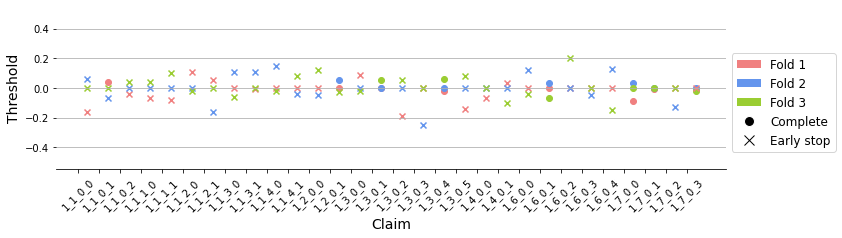

In [51]:
fig, ax = plt.subplots(figsize=(12,3))
sns.despine(left=True)
ax.xaxis.grid(False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.grid(True)
# ax.axhline(threshold, ls='--', color='dimgrey', label="Threshold")
ax.set_xlabel("Claim", fontsize=14)
ax.set_ylabel("Threshold", fontsize=14)

# title = trait.replace('_', '.') + ': ' + traits[trait]
# ax.set_title(title, fontsize=14)

# ax.spines['bottom'].set_color('lightgray')
ax.set_ylim(-0.55, 0.55)

medians_1_norm = np.array(medians_1) - median_val
medians_2_norm = np.array(medians_2) - median_val
medians_3_norm = np.array(medians_3) - median_val


conv_1 = list()
x_loc_conv_1 = list()
not_conv_1 = list()
x_loc_not_conv_1 = list()
i = 0
for t, m in zip(claims, medians_1_norm):
    if t in converged_1:
        conv_1.append(m)
        x_loc_conv_1.append(i)
    else:
        not_conv_1.append(m)
        x_loc_not_conv_1.append(i)
    i+= 1
    
conv_2 = list()
x_loc_conv_2 = list()
not_conv_2 = list()
x_loc_not_conv_2 = list()
i = 0
for t, m in zip(claims, medians_2_norm):
    if t in converged_2:
        conv_2.append(m)
        x_loc_conv_2.append(i)
    else:
        not_conv_2.append(m)
        x_loc_not_conv_2.append(i)
    i += 1
    
conv_3 = list()
x_loc_conv_3 = list()
not_conv_3 = list()
x_loc_not_conv_3 = list()
i = 0
for t, m in zip(claims, medians_3_norm):
    if t in converged_3:
        conv_3.append(m)
        x_loc_conv_3.append(i)
    else:
        not_conv_3.append(m)
        x_loc_not_conv_3.append(i)
    i += 1

ax.scatter(x_loc_conv_1, conv_1, c="lightcoral")
ax.scatter(x_loc_conv_2, conv_2, c="cornflowerblue")
ax.scatter(x_loc_conv_3, conv_3, c="yellowgreen")

ax.scatter(x_loc_not_conv_1, not_conv_1, c="lightcoral", marker="x")
ax.scatter(x_loc_not_conv_2, not_conv_2, c="cornflowerblue", marker="x")
ax.scatter(x_loc_not_conv_3, not_conv_3, c="yellowgreen", marker="x")

ax.set_xticks([i -0.4 for i in range(len(claims))], list(claims.keys()), rotation=45)

legend_elements = [
    Patch(facecolor='lightcoral', label='Fold 1'),
    Patch(facecolor='cornflowerblue', label='Fold 2'),
    Patch(facecolor='yellowgreen', label='Fold 3'),
    Line2D([0], [0], marker='o', color='w', label='Complete', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='x', color='black', label='Early stop', linestyle='', markerfacecolor='black', markersize=10),
                   ]
ax.legend(handles=legend_elements, loc='upper left', fontsize=12, bbox_to_anchor=(1, 0.75))
plt.show()

In [56]:
all_diffs = list()
all_diffs_CLAIM = list()

conv_diffs = list()
conv_diffs_CLAIM = list()

not_conv_diffs = list()
not_conv_diffs_CLAIM = list()

mixed_diffs = list()
mixed_diffs_CLAIM = list()

for t, m_1, m_2, m_3 in zip(claims, medians_1, medians_2, medians_3):
    diff = max([m_1, m_2, m_3]) - min([m_1, m_2, m_3])
    all_diffs.append(diff)
    all_diffs_CLAIM.append(t)
    if t in converged_1 and t in converged_2 and t in converged_3: 
        print(t, "\t%0.3f" % diff, "\tCONVERGED")
        conv_diffs.append(diff)
        conv_diffs_CLAIM.append(t)
    elif not t in converged_1 and not t in converged_2 and not t in converged_3:
        print(t, "\t%0.3f" % diff)
        not_conv_diffs.append(diff)
        not_conv_diffs_CLAIM.append(t)
    else:
        print(t, "\t%0.3f" % diff)
        mixed_diffs.append(diff)
        mixed_diffs_CLAIM.append(t)

1_1_0_0 	0.220
1_1_0_1 	0.110
1_1_0_2 	0.080
1_1_1_0 	0.110
1_1_1_1 	0.180
1_1_2_0 	0.130
1_1_2_1 	0.210
1_1_3_0 	0.170
1_1_3_1 	0.120
1_1_4_0 	0.170
1_1_4_1 	0.120
1_2_0_0 	0.170
1_2_0_1 	0.080
1_3_0_0 	0.110
1_3_0_1 	0.050 	CONVERGED
1_3_0_2 	0.240
1_3_0_3 	0.250
1_3_0_4 	0.080 	CONVERGED
1_3_0_5 	0.220
1_4_0_0 	0.070
1_4_0_1 	0.130
1_6_0_0 	0.160
1_6_0_1 	0.100 	CONVERGED
1_6_0_2 	0.200
1_6_0_3 	0.050
1_6_0_4 	0.280
1_7_0_0 	0.120 	CONVERGED
1_7_0_1 	0.010 	CONVERGED
1_7_0_2 	0.130
1_7_0_3 	0.020


### All claims

In [57]:
print("MAX:\t %.2f" % max(all_diffs))
print("MIN:\t %.2f" % min(all_diffs))
print("AVG:\t %.2f" % (sum(all_diffs)/len(all_diffs)))
print("STD:\t %.2f" % np.std(all_diffs))

MAX:	 0.28
MIN:	 0.01
AVG:	 0.14
STD:	 0.07


### Claims for which threshol-tuning is "complete" on all three folds

In [60]:
print("MAX:\t %.2f" % max(conv_diffs))
print("MIN:\t %.2f" % min(conv_diffs))
print("AVG:\t %.2f" % (sum(conv_diffs)/len(conv_diffs)))
print("STD:\t %.2f" % np.std(conv_diffs))

MAX:	 0.12
MIN:	 0.01
AVG:	 0.07
STD:	 0.04


### Claims for which threshol-tuning is "complete" on all none of the folds

In [58]:
print("MAX:\t %.2f" % max(not_conv_diffs))
print("MIN:\t %.2f" % min(not_conv_diffs))
print("AVG:\t %.2f" % (sum(not_conv_diffs)/len(not_conv_diffs)))
print("STD:\t %.2f" % np.std(not_conv_diffs))

MAX:	 0.28
MIN:	 0.05
AVG:	 0.16
STD:	 0.06


### Claims for which threshol-tuning is "complete" on some but not all of the three folds

In [59]:
print("MAX:\t %.2f" % max(mixed_diffs))
print("MIN:\t %.2f" % min(mixed_diffs))
print("AVG:\t %.2f" % (sum(mixed_diffs)/len(mixed_diffs)))
print("STD:\t %.2f" % np.std(mixed_diffs))

MAX:	 0.11
MIN:	 0.02
AVG:	 0.07
STD:	 0.04
